# Data Science Intern Challenge

In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline
sns.set_theme()

### Question 1: Given some sample data, write a program to answer the following
1. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 
2. What metric would you report for this dataset?
3. What is its value?


#### Load Data:

In [206]:
df = pd.read_csv(r'C:\Users\KY PHUOC\Downloads\2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv')
df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


### 1. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data

To analyze AOV, we have to determine what factors that impact on AOV

AOV = sum of order_amount / number of orders

Let visualize order_amount metric by boxplot

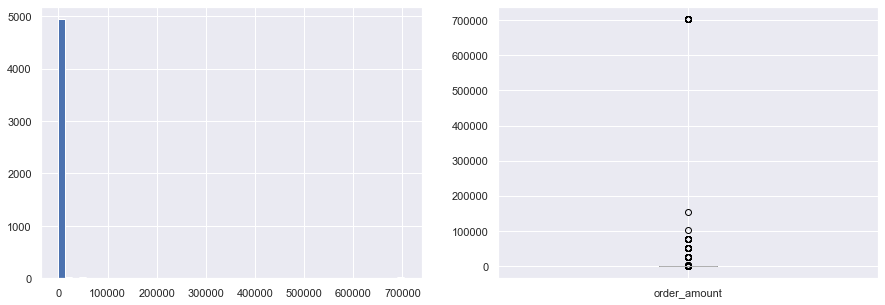

In [207]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
df["order_amount"].hist(bins=50, ax=axes[0])
df["order_amount"].to_frame().boxplot(ax=axes[1], vert=True);

From the histogram the data is seen to be skewed to the right (with the exception of a lot of skew to the right, or the "tail" of the histogram is to the right). From the boxplot we see that there are many points that are considered outliers. The point outliers can be handled by clipping the minimum and maximum values of the boxplot. This process that can be exploited as a sklearn API is as follows: 

In [208]:
from typing import Tuple
from sklearn.base import BaseEstimator, TransformerMixin


def find_boxplot_boundaries(
    col: pd.Series, whisker_coeff: float = 1.5
) -> Tuple[float, float]:
    """Findx minimum and maximum in boxplot.

    Args:
        col: a pandas serires of input.
        whisker_coeff: whisker coefficient in box plot
    """
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - whisker_coeff * IQR
    upper = Q3 + whisker_coeff * IQR
    return lower, upper


class BoxplotOutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, whisker_coeff: float = 1.5):
        self.whisker = whisker_coeff
        self.lower = None
        self.upper = None

    def fit(self, X: pd.Series):
        self.lower, self.upper = find_boxplot_boundaries(X, self.whisker)
        return self

    def transform(self, X):
        return X.clip(self.lower, self.upper)

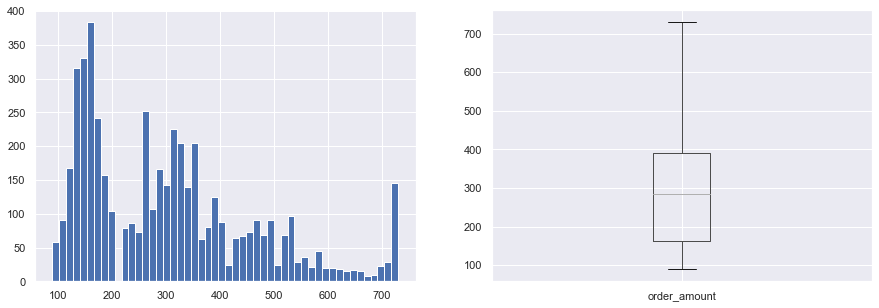

In [209]:
df["order_amount"] = BoxplotOutlierClipper().fit_transform(df["order_amount"])
df.astype({"order_amount" : int})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
df["order_amount"].hist(bins=50, ax=axes[0])
df["order_amount"].to_frame().boxplot(ax=axes[1], vert=True);

After clipping the data to the minimum and maximum of the box plot, we see that the data is less skewed. The box plot also shows that there are no more outliers. 

In [47]:
print(" Actual AOV =", df['order_amount'].sum()/df['order_id'].count())

 Actual AOV = 306.0327


#### After clipping outliers, the AOV of total orders is 306.0327

### 2. What metric would you report for this dataset? 

As a analyst, I would like to add 2 metrics in the report: sales in each day and number of order in each hour.

In [221]:
df['Day'] = df['created_at'].str[8:10]

df.Day = df.Day.astype('int64')
df.order_amount = df.order_amount.astype('int64')
df

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,Day
0,1,53,746,224,2,cash,2017-03-13 12:36:56,13
1,2,92,925,90,1,cash,2017-03-03 17:38:52,3
2,3,44,861,144,1,cash,2017-03-14 4:23:56,14
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37,26
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11,1
...,...,...,...,...,...,...,...,...
4995,4996,73,993,330,2,debit,2017-03-30 13:47:17,30
4996,4997,48,789,234,2,cash,2017-03-16 20:36:16,16
4997,4998,56,867,351,3,cash,2017-03-19 5:42:42,19
4998,4999,60,825,354,2,credit_card,2017-03-16 14:51:18,16


#### computing amount orders in terms of day

In [224]:
amount_day = df.groupby('Day')['order_amount'].sum().rename_axis('Day').reset_index(name='amount_day')
amount_day

,Day,amount_day
0,1,55364
1,2,55014
2,3,48244
3,4,49585
4,5,49740
5,6,42210
6,7,58831
7,8,43221
8,9,63972
9,10,47775


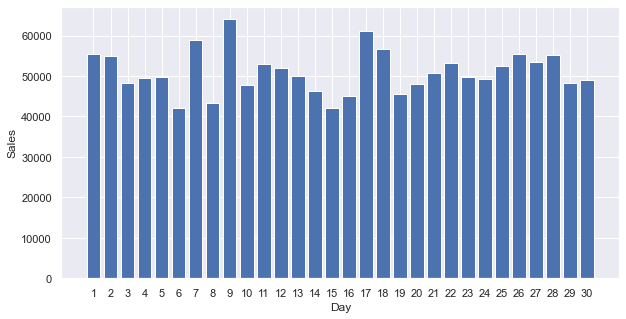

In [226]:
fig = plt.figure(figsize = (10, 5))
plt.bar(x=amount_day['Day'], height=amount_day['amount_day'])
plt.xticks(amount_day['Day'])
plt.xlabel('Day')
plt.ylabel('Sales')
plt.show()

#### computing number of orders in terms of hour

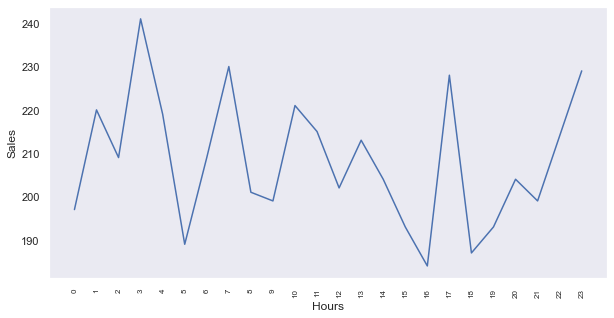

In [230]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['Hours'] = df['created_at'].dt.hour
sales_hours = df.groupby('Hours').count()['order_id']
hours = [hour for hour, sales in sales_hours.items()]
fig = plt.figure(figsize = (10, 5))
plt.plot(hours, sales_hours)
plt.grid()
plt.xticks(hours, rotation=90, size=8)
plt.xlabel('Hours')
plt.ylabel('Sales')
plt.show()

#### 3. What is it value?

- Firstly, in oder to come up with marketing strategy such as advertising or giving promotion, stakeholder has to know that the exatly days of month that the sales is high compared to average.
    
- Secondly, to reducce the cost of running marketing, advertising should be conducted according to the hour that customer purchase goods the most.

In [234]:
df_group = df.groupby('total_items')['order_amount'].sum().rename_axis('total_items').reset_index(name='total_amount')
df1 = df.groupby('total_items')['order_amount'].count().rename_axis('total_items').reset_index(name='count')
df1  =df1.drop("total_items", axis=1)
df_group['count'] = df1
df_group['AOV'] =df_group['total_amount']/df_group['count']
df_group['Avg_AOV']= df_group.groupby('total_items')['AOV'].median()
df_group

,total_items,total_amount,count,AOV,Avg_AOV
0,1,288872,1830,157.853552,NaN
1,2,562874,1832,307.245633,157.853552
2,3,431820,941,458.894793,307.245633
3,4,173472,293,592.054608,458.894793
4,5,53345,77,692.792208,592.054608
5,6,6570,9,730.000000,692.792208
6,8,730,1,730.000000,730.000000
7,2000,12410,17,730.000000,NaN


According to AOV mean, If the total items in one offer are 4, the business will receive AOV higher than average. Therefore, the company should apply trategy susch as prodiving discount if customer buy more 4 items at once or doing up-sell and cross-sell which is a form of increasing revenue and sales for businesses through activities that encourage customers to buy more products or services with higher value or buy other related products. 

### Question 2:
1. How many orders were shipped by Speedy Express in total?

SELECT count(OrderID) as amount_order 

FROM [Orders] 

where [ShipperID] in (select [ShipperID] from [Shippers] 

where [ShipperName] = 'Speedy Express')


#### The number of orders shipped by Speedy Express is 54

2. What is the last name of the employee with the most orders?

select LastName, count(*) as emp_num_order

from Employees join Orders on Employees.EmployeeID = Orders.EmployeeID

Group by Orders.EmployeeID

Order by count(Orders.OrderID) DESC


#### Peacock is the last name of employee with the most order

3. What product was ordered the most by customers in Germany?

select ProductName, MAX(Quantity)
FROM(
select Products.ProductName as ProductName, OrderDetails.Quantity

from Orders

JOIN Customers ON Orders.CustomerID=Customers.CustomerID

JOIN Products ON Products.ProductID=OrderDetails.ProductID

JOIN OrderDetails ON Orders.OrderID=OrderDetails.OrderID

WHERE Country = 'Germany'

Group By Products.ProductID

Order by  Quantity Desc);

#### Steeleye Stout is the most ordered item in Germany